# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [47]:
from decimal import Decimal
import matplotlib.pyplot as plt

import geomstats.backend as gs
import numpy as np
from nsimplices import *
from common import *
import scipy.stats as stats

gs.random.seed(2021)

In [48]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'osteosarcoma'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
rescale = True
print(f"Will save figs to {figs_dir}")

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma


# 2. Dataset Description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.

<td>
    <img src="figures/binarized_cells.png" width=400px />
</td>

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [49]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 650


The cells are grouped by treatment class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Additionally, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

This is shown by displaying the unique elements in the lists `treatments` and `lines`:

In [50]:
import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


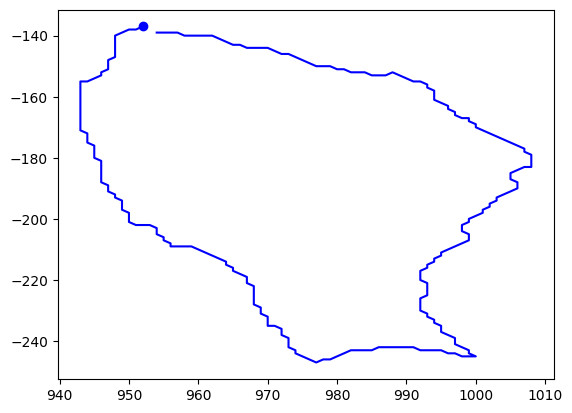

In [51]:
cell_idx = 1
plt.plot(cells[cell_idx][:, 0], cells[cell_idx][:, 1], "blue")
plt.plot(cells[cell_idx][0, 0], cells[cell_idx][0, 1], "blue", marker="o");

The size of each class is displayed below:

In [52]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


The above code also created a dictionnary `ds`, that contains the cell boundaries data sorted by `treatment` and cell `line`. To access all the cells corresponding to a given treatment and a given cell line, we use the syntax `ds[treatment][line]` as in the following code that computes the number of cells in the cytd-dlm8 class.

In [53]:
len(ds["cytd"]["dlm8"])

82

We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [54]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [55]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 200

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

(1116.1964538574218,
 1229.1335021972657,
 -283.2620025634766,
 -199.1779998779297)

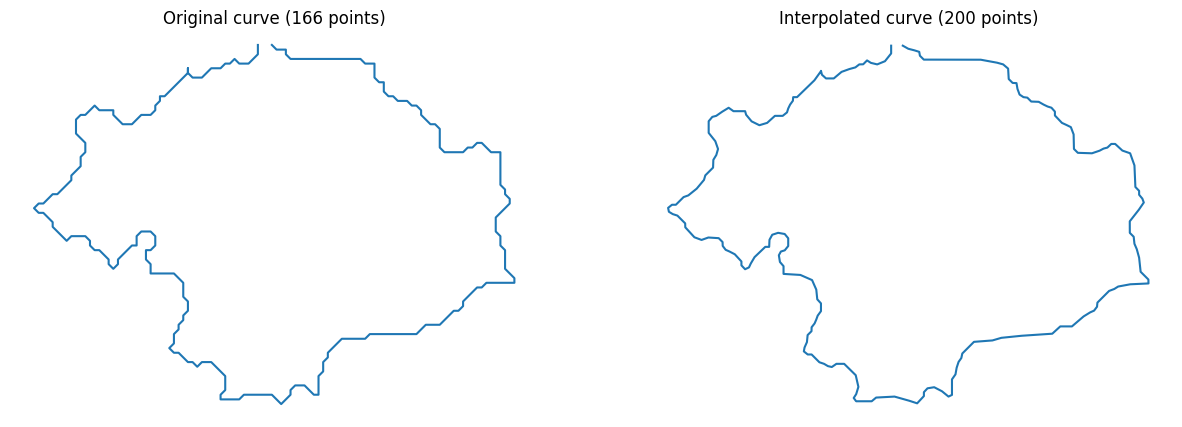

In [56]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
# plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [57]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

For each key treatment-control, we check that the number of sampling points is the one expected, i.e. `k_sampling_points`:

In [58]:
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


The shape of an array of cells in `ds_interp[treatment][cell]` is therefore: `("number of cells in treatment-line", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

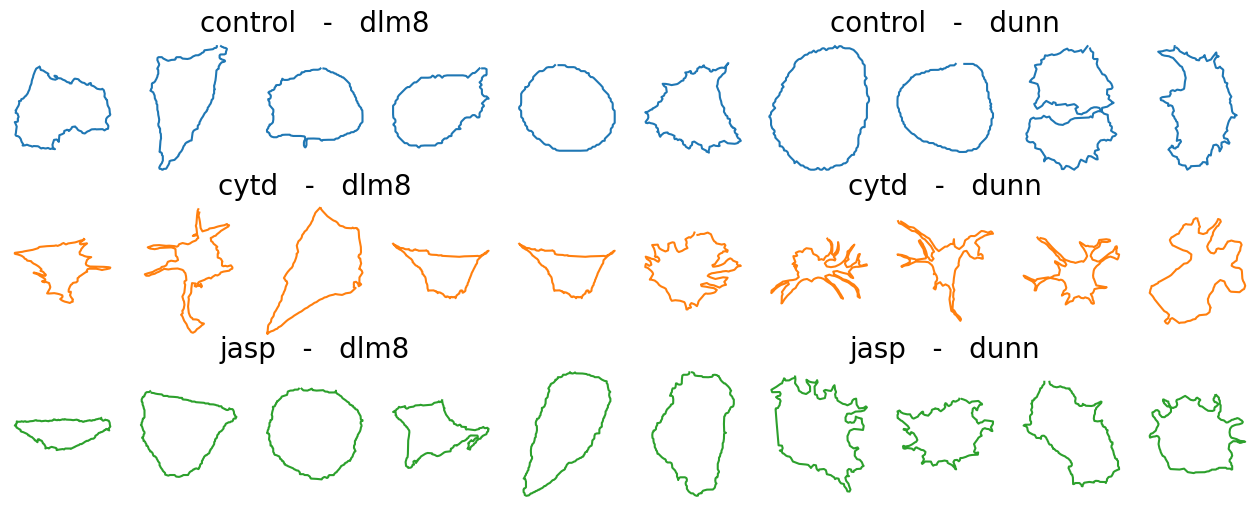

In [59]:
n_cells_to_plot = 5

fig = plt.figure(figsize=(16, 6))
count = 1
for i, treatment in enumerate(TREATMENTS):
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
            plt.xlim(-170, 170)
            plt.ylim(-170, 170)
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
# plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Remove duplicate samples in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [60]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks and reparamterization.

Additionally, since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). 

This exhaustive search is implemented in the function `exhaustive_align` in `common.py`.

Since the alignment procedure takes 10+ hours, we ran `osteosarocoma_align.py` and saved the results in `~/dyn/datasets/osteosarcoma/aligned`

In [61]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

BASE_CURVE = ds_proc["control"]["dlm8"][0]


Load aligned cells from txt files. These files were generated by calling `exhaustive_align` function in `osteosarcoma_align.py`.

In [62]:
aligned_folder = os.path.join(data_path, dataset_name, "aligned")
if rescale:
    aligned_folder = os.path.join(aligned_folder, "rescaled")
else:
    aligned_folder = os.patj.join(aligned_folder, "no_rescaled")

ds_align = {}
for treatment in TREATMENTS:
    ds_align[treatment] = {}
    for line in LINES:
        ds_align[treatment][line] = []
        cell_num = len(ds_proc[treatment][line])
        for i in range(cell_num):
            file_path = os.path.join(aligned_folder, f"{treatment}_{line}_{i}.txt")
            if not os.path.exists(file_path):
                file_path = os.path.join(aligned_folder, f"{treatment}_{line}_{i}_rotation_only.txt")
            cell = np.loadtxt(file_path)
            ds_align[treatment][line].append(cell)
        

Check we did not loss any cells after alignment

In [63]:
for treatment in TREATMENTS:
    for line in LINES:
        print(f"{treatment} and {line}: {len(ds_align[treatment][line])}")

control and dlm8: 114
control and dunn: 204
cytd and dlm8: 82
cytd and dunn: 93
jasp and dlm8: 62
jasp and dunn: 95


Visualize reference cell, unaligned cell and aligned cell.

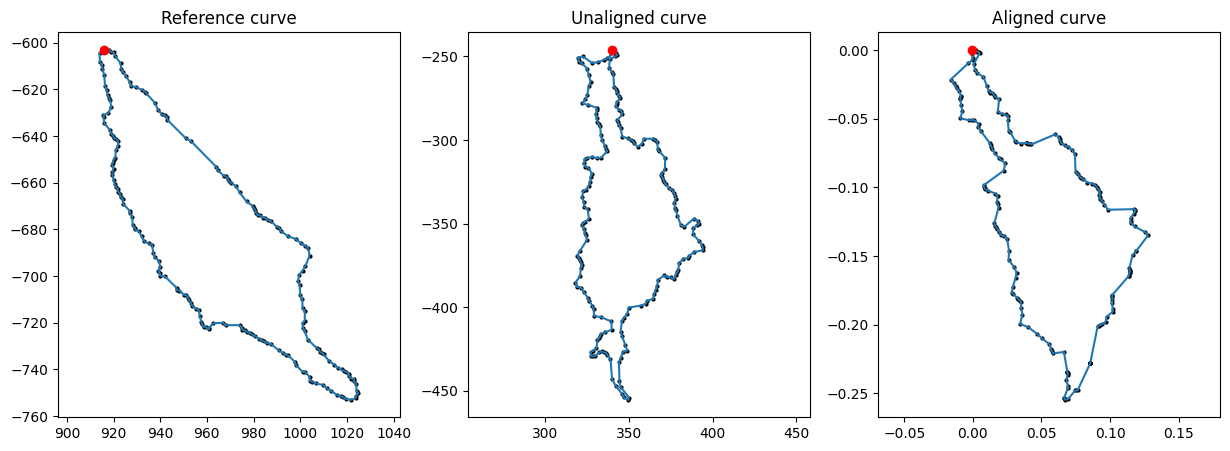

In [131]:
index = 24
unaligned_cell = ds_proc["cytd"]["dunn"][index]
aligned_cell = ds_align["cytd"]["dunn"][index]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot([BASE_CURVE[-1, 0], BASE_CURVE[0, 0]], [BASE_CURVE[-1, 1], BASE_CURVE[0, 1]], 'tab:blue')
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4, c='black')
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
# plt.plot([unaligned_cell[-1, 0], unaligned_cell[0, 0]], [unaligned_cell[-1, 1],unaligned_cell[0, 1]], 'tab:blue')
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4, c='black')
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
# plt.plot([aligned_cell[-1, 0], aligned_cell[0, 0]], [aligned_cell[-1, 1],aligned_cell[0, 1]], 'tab:blue')
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4, c='black')
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

plt.savefig(os.path.join(figs_dir, "alignment.svg"))
plt.savefig(os.path.join(figs_dir, "alignment.pdf"))


In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data Analysis

## Compute Mean Cell Shape of the Whole Dataset: "Global" Mean Shape

We want to compute the mean cell shape of the whole dataset. Thus, we first combine all the cell shape data into a single array.

In [65]:
from geomstats.geometry.euclidean import Euclidean
# from geomstats.geometry.discrete_curves import DiscreteCurves, L2CurvesMetric

k_sampling_points = 199
# CURVES_SPACE_SRV = DiscreteCurves(Euclidean(dim=2), k_sampling_points=k_sampling_points)
CURVES_SPACE_SRV = DiscreteCurvesStartingAtOrigin(ambient_dim=2, k_sampling_points=k_sampling_points)


In [66]:
cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(650, 199, 2)


Remove outliers using DeCOr-MDS, separately for DUNN and DLM8 cell lines.

In [67]:
def srv_dist(cell1, cell2):
    # return CURVES_SPACE_SRV.metric.dist(cell1, cell2) / k_sampling_points
    CURVES_SPACE_SRV.equip_with_metric(SRVMetric)

    return CURVES_SPACE_SRV.metric.dist(CURVES_SPACE_SRV.projection(cell1), \
                                        CURVES_SPACE_SRV.projection(cell2))
 
# compute pairwise distances
metric = 'SRV'
pairwise_dists = {}
pairwise_dists[metric] = parallel_dist(cell_shapes, srv_dist, k_sampling_points)

# run DeCOr-MDS
dim_start = 2
dim_end = 2
feature_num = 2


In [68]:
outlier_indices, subspace_dim , corr_pairwise_dis, corr_coord = nsimplices(pairwise_dists[metric], feature_num, dim_start, dim_end)
print(f"outlier_indices are: {outlier_indices}")

outlier_indices are: [ 97 195 302 382 386 523]


Visualize outlier cells to see if they are artifacts

Text(0.5, -0.01, '')

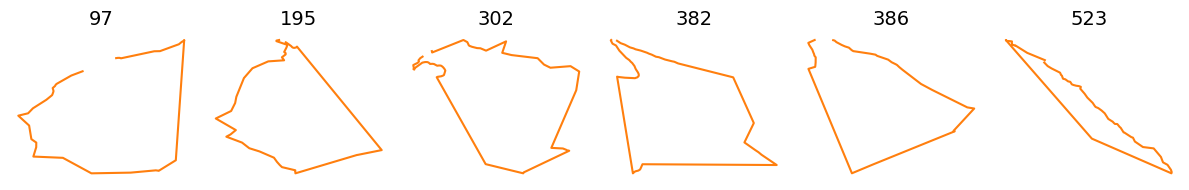

In [69]:
fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(outlier_indices),
    figsize=(2*len(outlier_indices), 2),
)


for i, outlier_index in enumerate(outlier_indices):
    one_cell = cell_shapes[outlier_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
    ax.set_title(f"{outlier_index}", fontsize=14)
    # ax.axis("off")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "outlier.svg"))

Text(0.5, -0.01, '')

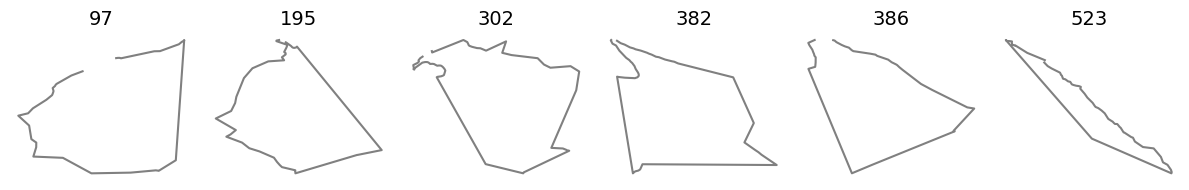

In [70]:
delete_indices = outlier_indices

fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(delete_indices),
    figsize=(2*len(delete_indices), 2),
)


for i, outlier_index in enumerate(delete_indices):
    one_cell = cell_shapes[outlier_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"gray")
    ax.set_title(f"{outlier_index}", fontsize=14)
    # ax.axis("off")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "delete_outlier.svg"))
# plt.savefig(os.path.join(figs_dir, "delete_outlier.pdf"))

After visual inspection, we decide to remove the outlier cells

In [71]:
cells, cell_shapes, lines, treatments, ds_proc, ds_align = remove_cells_two_layer(cells, cell_shapes, lines, treatments, ds_proc, ds_align, delete_indices)

In [72]:
print(f'Number of cells: {len(cells)}, Number of lines: {len(lines)}, Shape of cell_shapes: {cell_shapes.shape}')
for treatment, treatment_values in ds_align.items():
    for line, line_cells in treatment_values.items():
        print(f"Treatment: {treatment}, Cell line {line}: {len(line_cells)}")

Number of cells: 644, Number of lines: 644, Shape of cell_shapes: (644, 199, 2)
Treatment: control, Cell line dlm8: 113
Treatment: control, Cell line dunn: 202
Treatment: cytd, Cell line dlm8: 80
Treatment: cytd, Cell line dunn: 93
Treatment: jasp, Cell line dlm8: 61
Treatment: jasp, Cell line dunn: 95


We compute the mean cell shape by using the SRV metric defined on the space of curves' shapes. The space of curves' shape is a manifold: we use the Frechet mean, associated to the SRV metric, to get the mean cell shape.

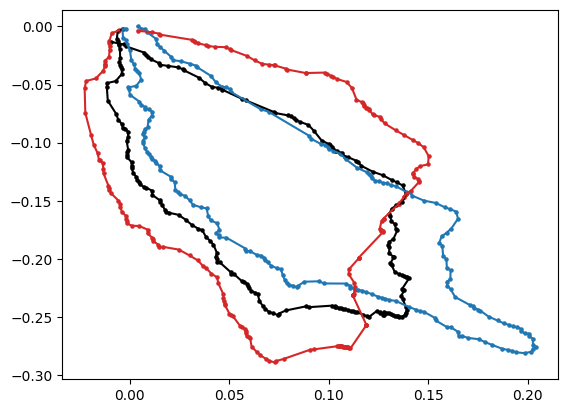

In [73]:
from geomstats.learning.frechet_mean import FrechetMean

# mean = FrechetMean(space=CURVES_SPACE_SRV)
mean = FrechetMean(CURVES_SPACE_SRV)
# cell_shapes_at_origin = CURVES_SPACE_SRV.projection(cell_shapes)
# print(cell_shapes_at_origin.shape)

mean.fit(cell_shapes[0:2])

mean_estimate = mean.estimate_

plt.scatter(mean_estimate[:, 0], mean_estimate[:, 1], color="black", s=5)
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black")

plt.scatter(cell_shapes[0, :, 0], cell_shapes[0, :, 1], color='tab:blue', s=5)
plt.plot(cell_shapes[0, :, 0], cell_shapes[0, :, 1], color='tab:blue')
plt.scatter(cell_shapes[1, :, 0], cell_shapes[1, :, 1], color='tab:red', s=5)
plt.plot(cell_shapes[1, :, 0], cell_shapes[1, :, 1], color='tab:red')


We observe X shape for the SRV mean cell of two cells. The blue curve shows the mean cell, the red and blue curves are the two cells used for computing the mean cell.

The mean cell shape does indeed look like a cell shape. We note that there is a discontinuity in the cell because we have modeled the curves' boundaries as open curves. The space of curves considered here is also the space of (open) discrete curves.

Unfortunately, sometimes there could be Nans in the values of the mean shape. If this is the case, this code removes them manually, and re-interpolate the mean shape.

In [74]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = interpolate(mean_estimate_clean, k_sampling_points)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(199, 2)
0
(199, 2)


We plot the mean cell shape, superimposed on top of the dataset of cells (displayed in light grey underneath).

(644, 199, 2)


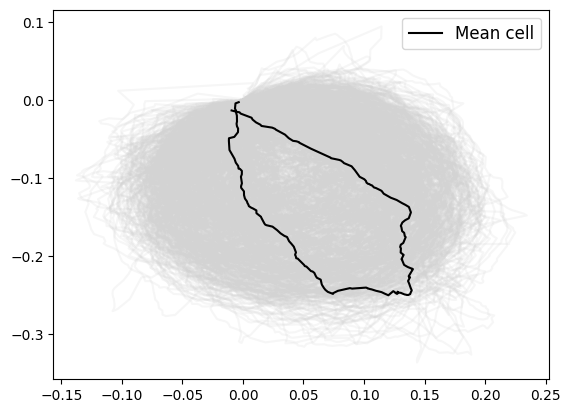

In [75]:
print(cell_shapes.shape)
for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_clean[:, 0], mean_estimate_clean[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We see that the scale and alignment of the mean shape is slightly off. This makes sense, as our computations have quotiented out scale and alignment. We correct it manually.

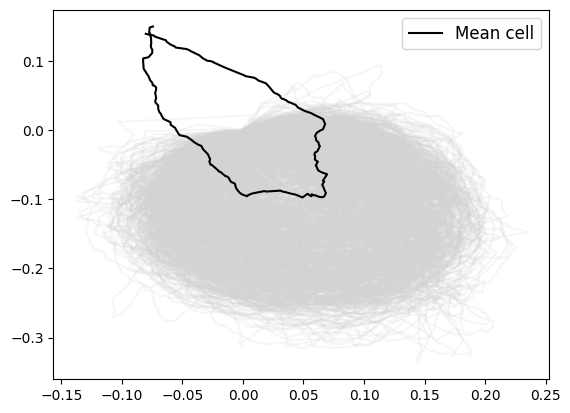

In [76]:
mean_estimate_aligned = (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We visualize the same plot, but now:
- closing the mean shape that becomes a closed curve
- plotting underneath the mean shape the distribution of the sampling points of all the curves of the dataset, through a kernel density estimation.

Visualizing the full datasets of 640+ cells takes a long time. Therefore, we also select only 200 cells, randomly, within the dataset.

In [77]:
# mean_estimate_aligned_bis = gs.vstack(
#     [mean_estimate_aligned[4:], mean_estimate_aligned[-1]]
# )

In [78]:
# from scipy.stats import gaussian_kde

# cells_to_plot = cell_shapes[gs.random.randint(len(cell_shapes), size=200)]
# points_to_plot = cells_to_plot.reshape(-1, 2)

# z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
# z_norm = z / z.max()

# plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
# plt.plot(
#     mean_estimate_aligned_bis[:, 0],
#     mean_estimate_aligned_bis[:, 1],
#     "black",
#     label="Mean cell",
# )
# plt.legend(fontsize=12)
# plt.title("Global mean shape superimposed on the\n dataset of cells", fontsize=14)

# # plt.savefig("global_mean_shape.svg")

This plot allows to verify that the mean shape that has been computed makes sense.

Also we compute the linear mean

In [79]:
print(cell_shapes[0].shape)
linear_mean_estimate = gs.mean(cell_shapes, axis=0)
print(linear_mean_estimate.shape)
print(gs.sum(gs.isnan(linear_mean_estimate)))
linear_mean_estimate_clean = linear_mean_estimate[~gs.isnan(gs.sum(linear_mean_estimate, axis=1)), :]
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_clean = interpolate(linear_mean_estimate_clean, k_sampling_points)

print(gs.sum(gs.isnan(linear_mean_estimate_clean)))
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_aligned =  (
    linear_mean_estimate_clean - gs.mean(linear_mean_estimate_clean, axis=0)
)

# for cell in cell_shapes:
#     plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

# plt.plot(
#     linear_mean_estimate_aligned[:, 0], linear_mean_estimate_aligned[:, 1], "black", label="Mean cell"
# )
# plt.legend(fontsize=12);

(199, 2)
(199, 2)
0
(199, 2)
0
(199, 2)


Plot SRV mean cell versus linear mean cell

(-0.09081533705640288,
 0.08952917882717942,
 -0.09084610531200979,
 0.1104945632857602)

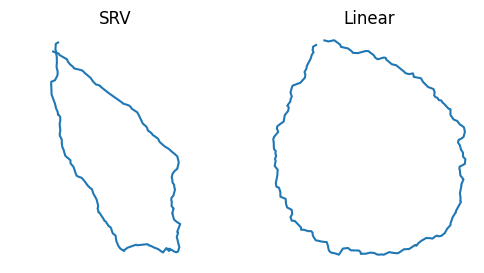

In [80]:
fig = plt.figure(figsize=(6, 3))

fig.add_subplot(121)
plt.plot(mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1])
plt.axis("equal")
plt.title("SRV")
plt.axis("off")

fig.add_subplot(122)
plt.plot(linear_mean_estimate_aligned[:, 0], linear_mean_estimate_aligned[:, 1])
plt.axis("equal")
plt.title("Linear")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "global_mean.svg"))
# plt.savefig(os.path.join(figs_dir, "global_mean.pdf"))



Not sure how but the 1.55 makes the seperation of the histogram better, though it does not look like the mean of the cell shapes.

# Analyze Distances to the "Global"  Mean Shape

We consider each of the subgroups of cells, defined by their treatment and cell line. We wish to study how far each of this group is from the global mean shape. We compute the list of distances to the global mean shape.

In [81]:
metric = 'SRV'
dists_to_global_mean = {}
dists_to_global_mean_list = {}
print(mean_estimate_aligned.shape)
x = ds_align['control']['dunn'][0]

print(x.shape)
aligned_x = CURVES_SPACE_SRV.projection(x)

print(CURVES_SPACE_SRV.projection(x).shape)
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align, 
    func=lambda x: CURVES_SPACE_SRV.metric.dist(CURVES_SPACE_SRV.projection(x), CURVES_SPACE_SRV.projection(mean_estimate_aligned))
)

dists_to_global_mean_list[metric] = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][t][l])

(199, 2)
(199, 2)
(198, 2)


Compute distances to linear mean

In [82]:
metric = 'Linear'
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align, func=lambda x: gs.linalg.norm(linear_mean_estimate_aligned - x) 
)

dists_to_global_mean_list[metric] = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][t][l])

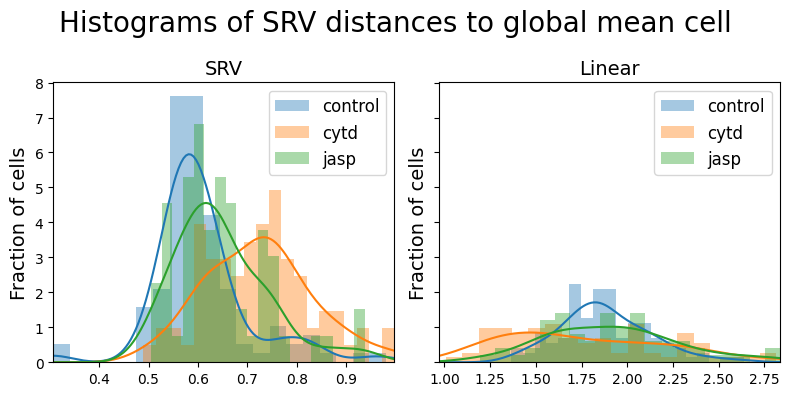

In [132]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, tight_layout=True, figsize=(8, 4))

line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)
    
    for i, treatment in enumerate(TREATMENTS):
        distances = dists_to_global_mean[metric][treatment][line][~gs.isnan(dists_to_global_mean[metric][treatment][line])]
        
        
        axs[j].hist(distances, bins=20, alpha=0.4, density=True, label=treatment, color=f"C{i}")
        kde = stats.gaussian_kde(distances)
        axs[j].plot(xx, kde(xx), color=f"C{i}")
        axs[j].set_xlim((min_dists, max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"{metric}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of SRV distances to global mean cell", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.pdf"))


control SRV
counts are: [0.18806504 1.12839023 2.06871541 6.20614624 5.26582105 3.57323572
 4.32549587 3.19710564 2.06871541 3.38517068 1.5045203  1.31645526
 0.94032519 1.12839023 0.37613008 0.37613008 0.18806504 0.18806504
 0.18806504 0.37613008]
bin_edges are: [0.46657798 0.49290129 0.5192246  0.54554792 0.57187123 0.59819455
 0.62451786 0.65084118 0.67716449 0.7034878  0.72981112 0.75613443
 0.78245775 0.80878106 0.83510437 0.86142769 0.887751   0.91407432
 0.94039763 0.96672094 0.99304426]
cytd SRV
counts are: [1.96961887 1.96961887 0.65653962 0.         2.62615849 2.62615849
 1.96961887 5.9088566  7.87847547 5.25231698 6.56539622 4.59577736
 3.93923773 5.25231698 3.93923773 1.96961887 1.96961887 0.
 0.         1.96961887]
bin_edges are: [0.62332773 0.63970555 0.65608337 0.67246119 0.68883902 0.70521684
 0.72159466 0.73797248 0.7543503  0.77072812 0.78710594 0.80348376
 0.81986158 0.8362394  0.85261722 0.86899504 0.88537286 0.90175068
 0.9181285  0.93450632 0.95088415]
jasp SRV
co

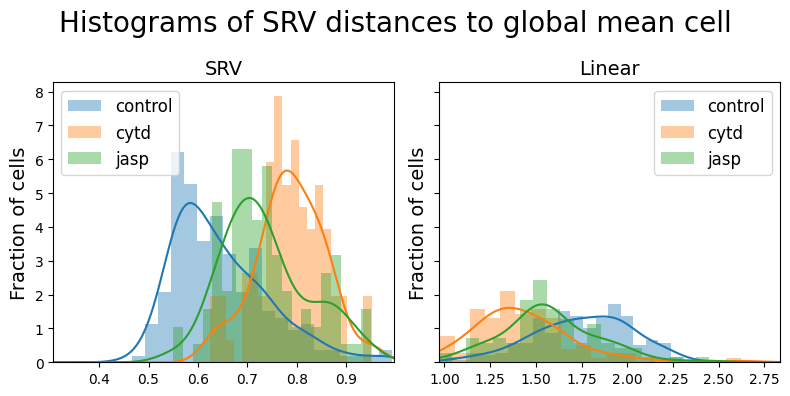

In [133]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, tight_layout=True, figsize=(8, 4))

line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)
    
    for i, treatment in enumerate(TREATMENTS):
        distances = dists_to_global_mean[metric][treatment][line][~gs.isnan(dists_to_global_mean[metric][treatment][line])]
        counts, bin_edges, _ = axs[j].hist(distances, bins=20, alpha=0.4, density=True, label=treatment, color=f"C{i}")
        print(treatment, metric)
        print("counts are:", counts)
        print("bin_edges are:", bin_edges)
        kde = stats.gaussian_kde(distances)
        axs[j].plot(xx, kde(xx), color=f"C{i}")
        axs[j].set_xlim((min_dists, max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"{metric}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of SRV distances to global mean cell", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.pdf"))


Calculate the ratio of overlapping regions between pairwise treatment groups

In [85]:
for line in LINES:
    for metric in METRICS:
        for i in range(len(TREATMENTS)):
            tmt1 = TREATMENTS[i]
            for j in range(i+1, len(TREATMENTS)):
                tmt2 = TREATMENTS[j]
                distance1 = dists_to_global_mean[metric][tmt1][line][~gs.isnan(dists_to_global_mean[metric][tmt1][line])]
                distance2 = dists_to_global_mean[metric][tmt2][line][~gs.isnan(dists_to_global_mean[metric][tmt2][line])]
                ratio = overlap_ratio(distance1, distance2)
                print(f"For {line} cell line, using {metric} metric, the ratio of overlapping regions between {tmt1} and {tmt2} is {round(ratio,2)}")
                

For dlm8 cell line, using SRV metric, the ratio of overlapping regions between control and cytd is 0.51
For dlm8 cell line, using SRV metric, the ratio of overlapping regions between control and jasp is 0.79
For dlm8 cell line, using SRV metric, the ratio of overlapping regions between cytd and jasp is 0.69
For dlm8 cell line, using Linear metric, the ratio of overlapping regions between control and cytd is 0.62
For dlm8 cell line, using Linear metric, the ratio of overlapping regions between control and jasp is 0.81
For dlm8 cell line, using Linear metric, the ratio of overlapping regions between cytd and jasp is 0.81
For dunn cell line, using SRV metric, the ratio of overlapping regions between control and cytd is 0.39
For dunn cell line, using SRV metric, the ratio of overlapping regions between control and jasp is 0.59
For dunn cell line, using SRV metric, the ratio of overlapping regions between cytd and jasp is 0.66
For dunn cell line, using Linear metric, the ratio of overlappin

Conduct T-test to test if the two samples have the same expected average

In [86]:
for line in LINES:
    for metric in METRICS:
        for i in range(len(TREATMENTS)):
            tmt1 = TREATMENTS[i]
            for j in range(i+1, len(TREATMENTS)):
                tmt2 = TREATMENTS[j]
                distance1 = dists_to_global_mean[metric][tmt1][line][~gs.isnan(dists_to_global_mean[metric][tmt1][line])]
                distance2 = dists_to_global_mean[metric][tmt2][line][~gs.isnan(dists_to_global_mean[metric][tmt2][line])]
                t_statistic, p_value = stats.ttest_ind(distance1, distance2)
                print(f"Significance of differences for {line} between {tmt1} and {tmt2} using {metric} metric is: {'%.2e' % Decimal(p_value)}")

Significance of differences for dlm8 between control and cytd using SRV metric is: 6.58e-13
Significance of differences for dlm8 between control and jasp using SRV metric is: 8.42e-03
Significance of differences for dlm8 between cytd and jasp using SRV metric is: 3.89e-05
Significance of differences for dlm8 between control and cytd using Linear metric is: 2.34e-02
Significance of differences for dlm8 between control and jasp using Linear metric is: 4.08e-01
Significance of differences for dlm8 between cytd and jasp using Linear metric is: 3.05e-02
Significance of differences for dunn between control and cytd using SRV metric is: 1.04e-28
Significance of differences for dunn between control and jasp using SRV metric is: 4.82e-13
Significance of differences for dunn between cytd and jasp using SRV metric is: 2.47e-05
Significance of differences for dunn between control and cytd using Linear metric is: 2.00e-19
Significance of differences for dunn between control and jasp using Linear me

Conduct statistical test to test if the two samples have the same expected average

In [87]:
for line in LINES:
    for metric in METRICS:
        for i in range(len(TREATMENTS)):
            tmt1 = TREATMENTS[i]
            for j in range(i+1, len(TREATMENTS)):
                tmt2 = TREATMENTS[j]
                distances1 = dists_to_global_mean[metric][tmt1][line][
                    ~gs.isnan(dists_to_global_mean[metric][tmt1][line])]
    
                distances2 = dists_to_global_mean[metric][tmt2][line][
                    ~gs.isnan(dists_to_global_mean[metric][tmt2][line])]
                t_statistic, p_value = stats.ttest_ind(distances1, distances2)
                print(f"Significance of differences between {tmt1} and {tmt2} using {metric} metric is: {p_value}")

Significance of differences between control and cytd using SRV metric is: 6.582310248090377e-13
Significance of differences between control and jasp using SRV metric is: 0.008415155840974981
Significance of differences between cytd and jasp using SRV metric is: 3.886599458883123e-05
Significance of differences between control and cytd using Linear metric is: 0.023377813645782328
Significance of differences between control and jasp using Linear metric is: 0.4079997052851656
Significance of differences between cytd and jasp using Linear metric is: 0.030460013270191964
Significance of differences between control and cytd using SRV metric is: 1.0396323748930308e-28
Significance of differences between control and jasp using SRV metric is: 4.823396781918528e-13
Significance of differences between cytd and jasp using SRV metric is: 2.4730207070953238e-05
Significance of differences between control and cytd using Linear metric is: 1.997975205149603e-19
Significance of differences between contr

Let's analyze bi-modal distribution for the control group of dunn cell line using SRV metric

We consider two groups: cells with [0.50446098, 0.53168803) - distance to the mean, cells with [0.72227743, 0.74950448) distance to the mean, and find the modes of the two groups

0.4665779768527347 0.9930442580696541
[44, 47, 52, 55, 121, 133, 149, 155]
[81, 83, 161, 162, 164, 173, 175, 178, 179, 182, 190, 193]


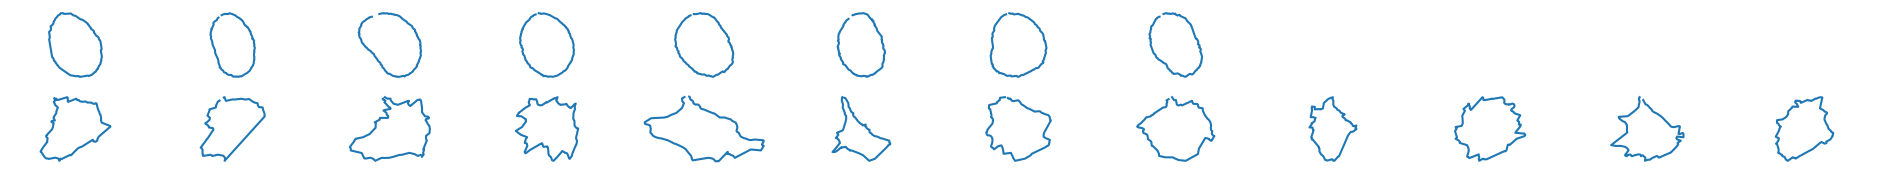

In [94]:
line = 'dunn'
treatment = 'control'
metric = 'SRV'
distances = dists_to_global_mean[metric][treatment][line]
print(min(distances), max(distances))
group_1_left = 0.50446098
group_1_right = 0.53168803
group_2_left = 0.72227743
group_2_right = 0.74950448
group_1_indices = [i for i, element in enumerate(distances) if element <= group_1_right and element > group_1_left]
group_2_indices = [i for i, element in enumerate(distances) if element <= group_2_right and element > group_2_left]
print(group_1_indices)
print(group_2_indices)
group_1_cells = ds_align[treatment][line][group_1_indices,:,:]
group_2_cells = ds_align[treatment][line][group_2_indices,:,:]

col_num = max(len(group_1_indices), len(group_2_indices))
fig = plt.figure(figsize=(2*col_num, 2))
count = 1
for index in range(len(group_1_indices)):
    cell = group_1_cells[index]
    fig.add_subplot(2, col_num, count)
    count += 1
    plt.plot(cell[:, 0], cell[:, 1])
    plt.axis("equal")
    plt.axis("off")

count = max(len(group_1_indices), len(group_2_indices))+1
for index in range(len(group_2_indices)):
    cell = group_2_cells[index]
    fig.add_subplot(2, col_num, count)
    count += 1
    plt.plot(cell[:, 0], cell[:, 1])
    plt.axis("equal")
    plt.axis("off")

# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.pdf"))

We then analyze bi-modal distribution for the jadp group of dunn cell line using SRV metric

We consider two groups: cells with [0.68583038, 0.77430819) - distance to the mean, cells with [0.84066655, 0.90702491) distance to the mean, and find the modes of the two groups

0.5490898322343648 0.9492500470218348


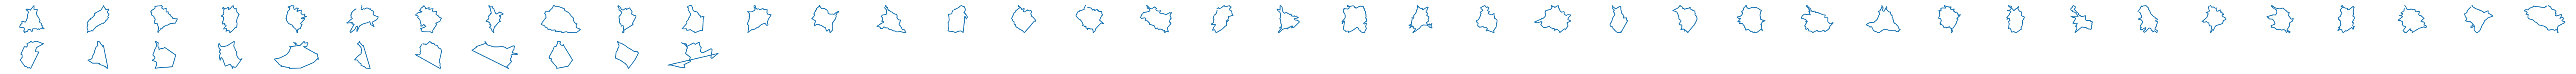

In [95]:
line = 'dunn'
treatment = 'jasp'
metric = 'SRV'
distances = dists_to_global_mean[metric][treatment][line]
print(min(distances), max(distances))
group_1_left = 0.68583038
group_1_right = 0.77430819
group_2_left = 0.84066655
group_2_right = 0.90702491
group_1_indices = [i for i, element in enumerate(distances) if element <= group_1_right and element > group_1_left]
group_2_indices = [i for i, element in enumerate(distances) if element <= group_2_right and element > group_2_left]
group_1_cells = np.array(ds_align[treatment][line])[group_1_indices,:,:]
group_2_cells = np.array(ds_align[treatment][line])[group_2_indices,:,:]

col_num = max(len(group_1_indices), len(group_2_indices))
fig = plt.figure(figsize=(2*col_num, 2))
count = 1
for index in range(len(group_1_indices)):
    cell = group_1_cells[index]
    fig.add_subplot(2, col_num, count)
    count += 1
    plt.plot(cell[:, 0], cell[:, 1])
    plt.axis("equal")
    plt.axis("off")

count = col_num+1
for index in range(len(group_2_indices)):
    cell = group_2_cells[index]
    fig.add_subplot(2, col_num, count)
    count += 1
    plt.plot(cell[:, 0], cell[:, 1])
    plt.axis("equal")
    plt.axis("off")

# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.pdf"))

# Visualization of the Mean of each Treatment

The mean distances to the global mean shape differ. We also plot the mean shape for each of the subgroup, to get intuition on how the mean shape of each subgroup looks like.

We first calculate the SRV mean

In [96]:
mean_treatment_cells = {}
for treatment in TREATMENTS:
    treatment_cells = []
    for line in LINES:
        treatment_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(CURVES_SPACE_SRV.projection(gs.array(treatment_cells)))
    mean_treatment_cells[treatment] = mean_estimator.estimate_

In [97]:
mean_line_cells = {}
for line in LINES:
    line_cells = []
    for treatment in TREATMENTS:
        line_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(CURVES_SPACE_SRV.projection(gs.array(line_cells)))
    mean_line_cells[line] = mean_estimator.estimate_

In [98]:
mean_cells = {}
metric = 'SRV'
mean_cells[metric] = {}
for treatment in TREATMENTS:
    mean_cells[metric][treatment] = {}
    for line in LINES:
        mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
        mean_estimator.fit(CURVES_SPACE_SRV.projection(gs.array(ds_align[treatment][line])))
        mean_cells[metric][treatment][line] = mean_estimator.estimate_

We then calculate the linear mean

In [99]:
metric = 'Linear'
mean_cells[metric] = {}
for treatment in TREATMENTS:
    mean_cells[metric][treatment] = {}
    for line in LINES:
        mean_cells[metric][treatment][line] = gs.mean(ds_align[treatment][line], axis=0)

While the mean shapes of the control groups (for both cell lines) look regular, we observe that:
- the mean shape for cytd is the most irregular (for both cell lines)
- while the mean shape for jasp is more elongated for dlm8 cell line, and more irregular for dunn cell line.

# Distance of the Cell Shapes to their Own Mean Shape

Lastly, we evaluate how each subgroup of cell shapes is distributed around the mean shape of their specific subgroup.

In [100]:
dists_to_own_mean = {}

nan_ids = {}
for metric in METRICS:
    dists_to_own_mean[metric] = {}
    for treatment in TREATMENTS:
        dists_to_own_mean[metric][treatment] = {}
        nan_ids[treatment] = {}
        for line in LINES:
            dists = []
            ids = []
            for i_curve, curve in enumerate(ds_align[treatment][line]):
                if metric == 'SRV':
                    one_dist = CURVES_SPACE_SRV.metric.dist(CURVES_SPACE_SRV.projection(curve), mean_cells[metric][treatment][line])
                else:
                    one_dist = gs.linalg.norm(curve - mean_cells[metric][treatment][line])
                if ~gs.isnan(one_dist):
                    dists.append(one_dist)
                else:
                    ids.append(i_curve)
            dists_to_own_mean[metric][treatment][line] = dists
            nan_ids[treatment][line] = ids

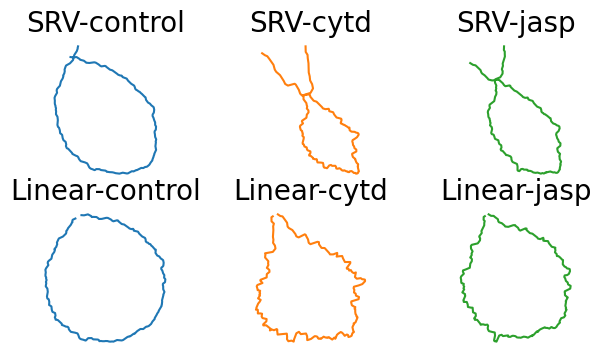

In [138]:
line = 'dunn'

fig, axes = plt.subplots(
    ncols=len(TREATMENTS),
    nrows=len(METRICS),
    figsize=(2.5*len(TREATMENTS), 2*len(METRICS)))

for j, metric in enumerate(METRICS):
    for i, treatment in enumerate(TREATMENTS):
        ax = axes[j, i]
        mean_cell = mean_cells[metric][treatment][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{i}")
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(f"{metric}-{treatment}", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.pdf"))

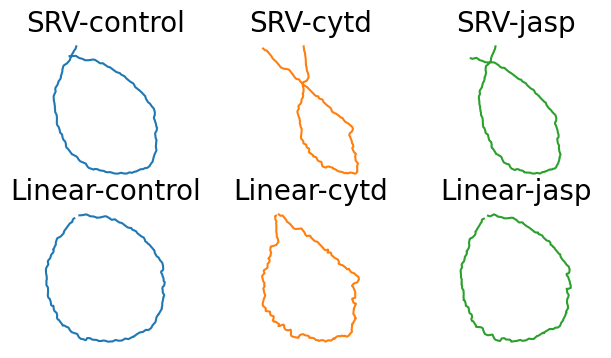

In [139]:
line = 'dlm8'

fig, axes = plt.subplots(
    ncols=len(TREATMENTS),
    nrows=len(METRICS),
    figsize=(2.5*len(TREATMENTS), 2*len(METRICS)))

for j, metric in enumerate(METRICS):
    for i, treatment in enumerate(TREATMENTS):
        ax = axes[j, i]
        mean_cell = mean_cells[metric][treatment][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{i}")
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(f"{metric}-{treatment}", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.pdf"))

The above code find a given number of quantiles within the distance's histogram, using SRV metric and own mean, and plots the corresponding cell, for each treatment and each cell line.

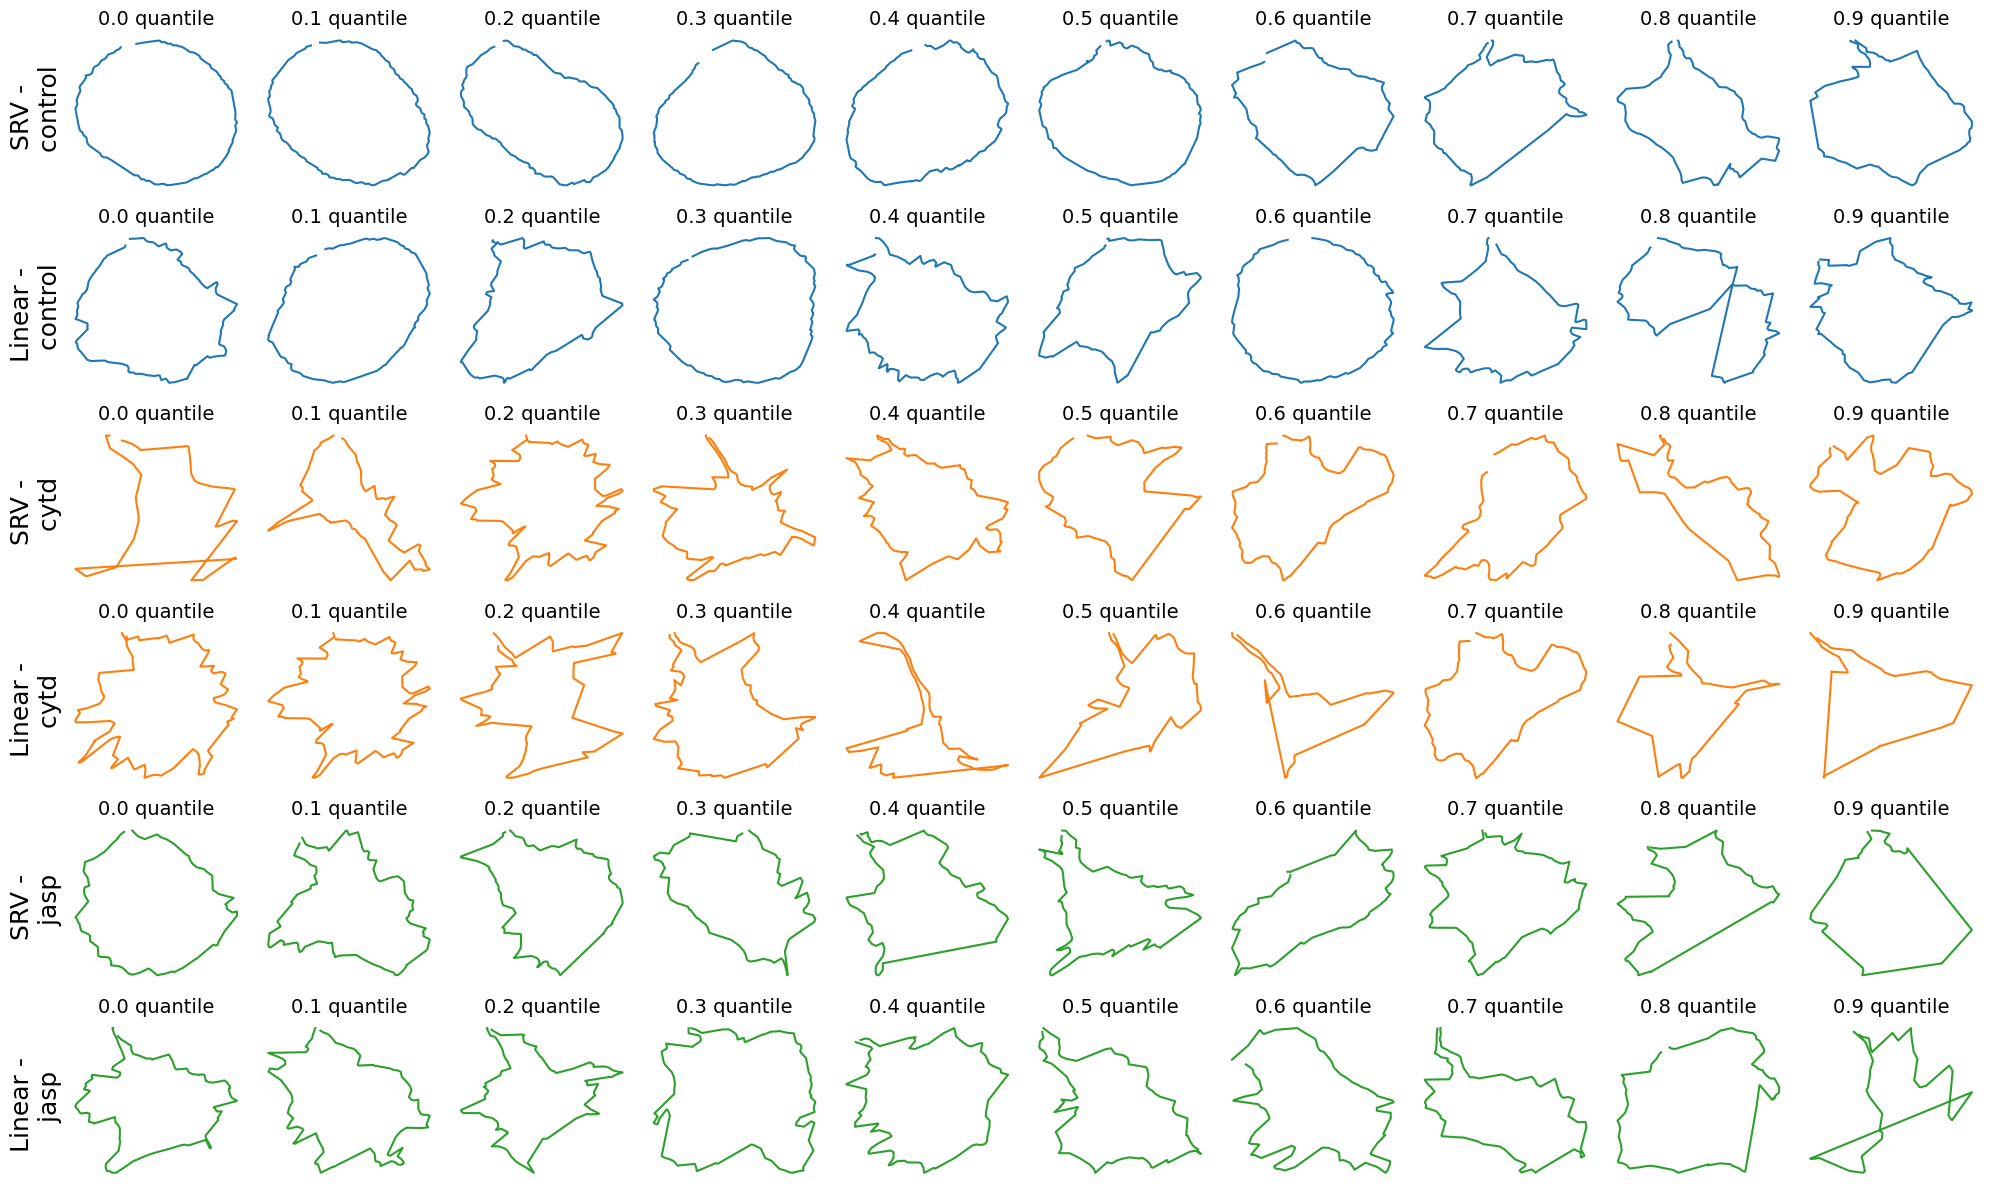

In [134]:
line = 'dunn'
n_quantiles = 10

fig, axes = plt.subplots(
    nrows=len(TREATMENTS)*len(METRICS),
    ncols=n_quantiles,
    figsize=(20, 2 * len(TREATMENTS) * len(METRICS)),
)

for i, treatment in enumerate(TREATMENTS):
    for j, metric in enumerate(METRICS):
        dists_list = dists_to_own_mean[metric][treatment][line]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[treatment][line])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2*i+j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{metric} - \n {treatment}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.pdf"))


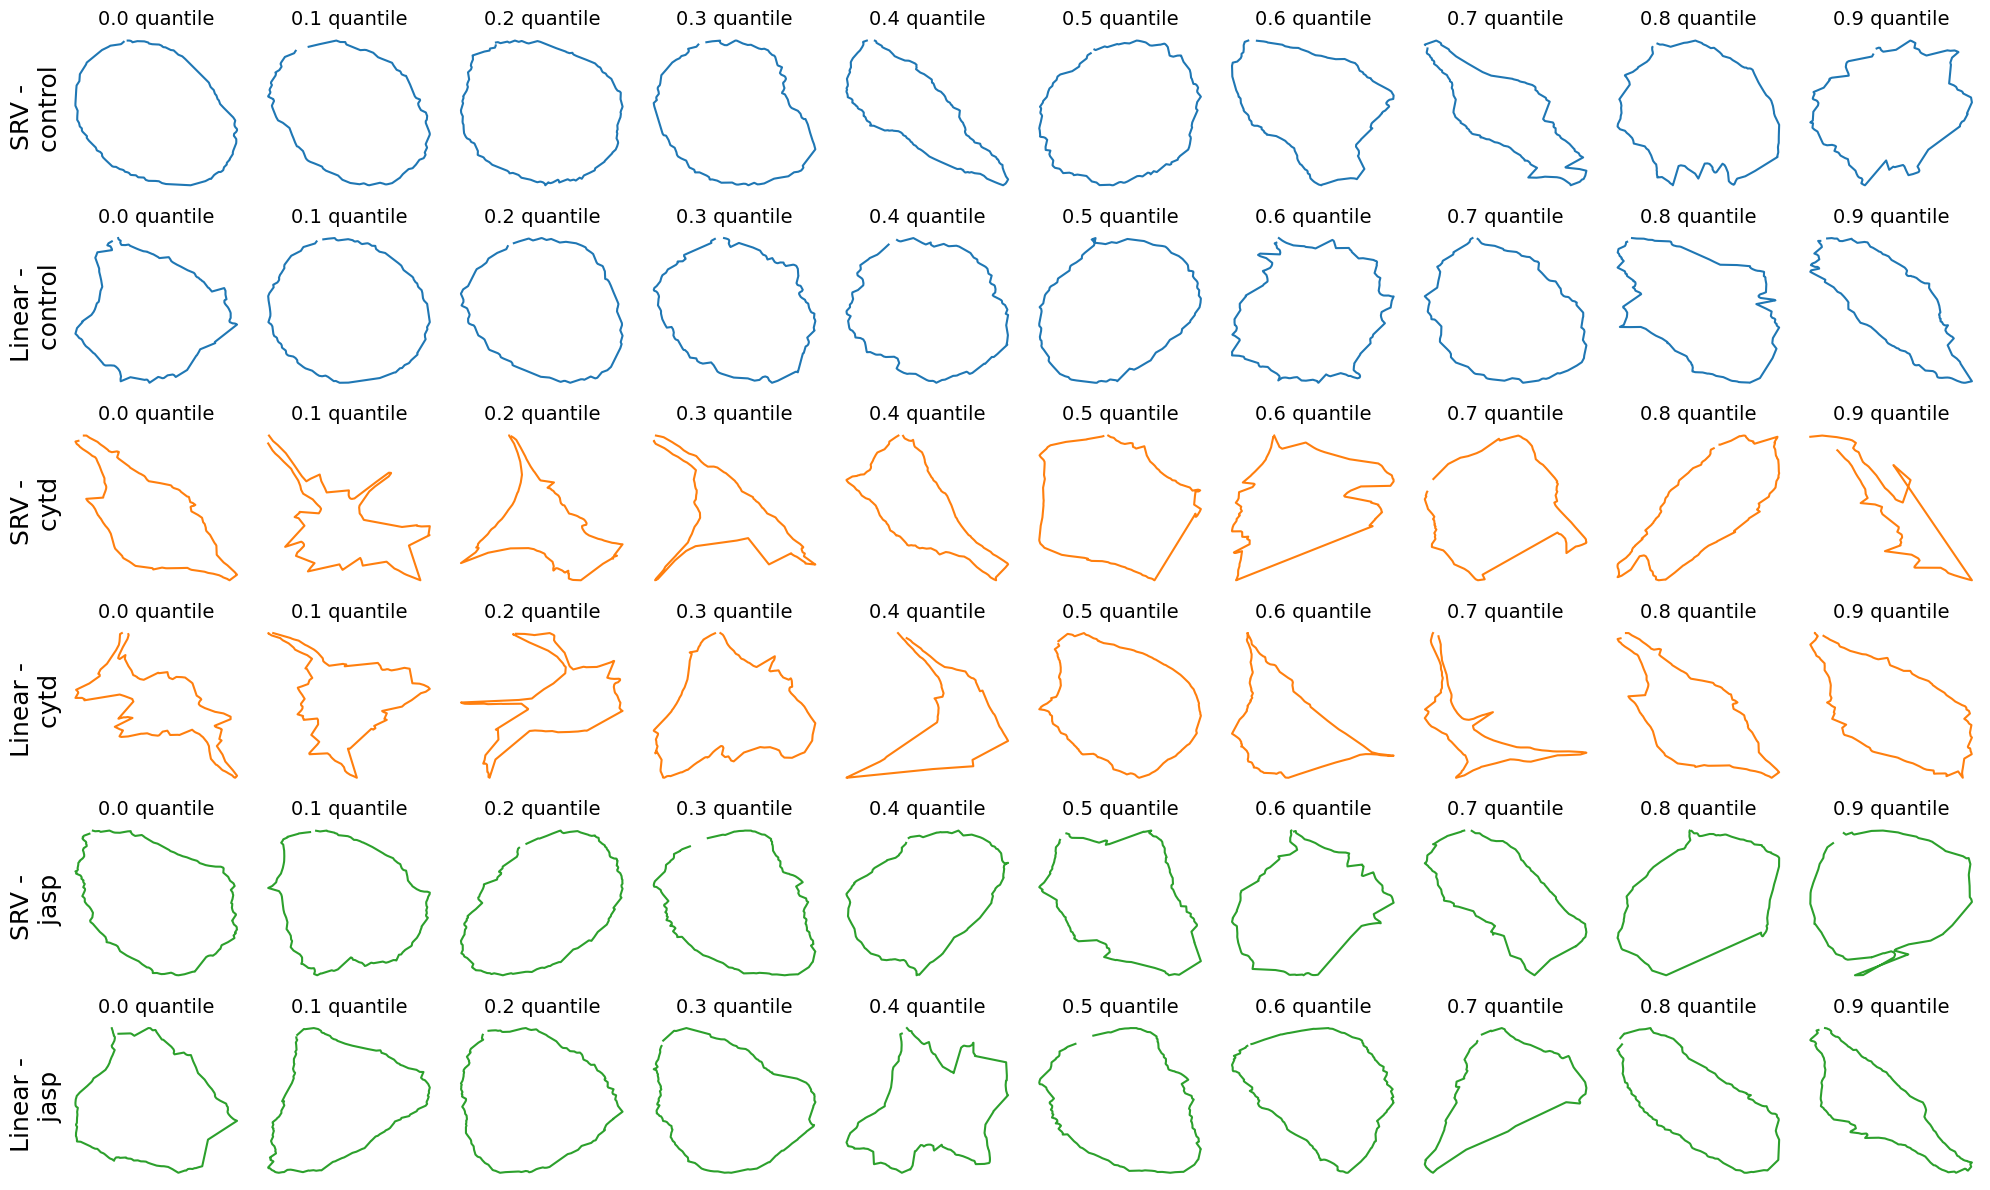

In [135]:
line = 'dlm8'
n_quantiles = 10

fig, axes = plt.subplots(
    nrows=len(TREATMENTS)*len(METRICS),
    ncols=n_quantiles,
    figsize=(20, 2 * len(TREATMENTS) * len(METRICS)),
)

for i, treatment in enumerate(TREATMENTS):
    for j, metric in enumerate(METRICS):
        dists_list = dists_to_own_mean[metric][treatment][line]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[treatment][line])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2*i+j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{metric} - \n {treatment}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.pdf"))


The above code find a given number of quantiles within the distance's histogram, using linear metric and own mean, and plots the corresponding cell, for each treatment and each cell line.

# Dimensionality Reduction

We use the following experiments to illustrate how SRV metric can help with dimensionality reduction 

Calculate MDS statistics for dimension 2

In [105]:
from sklearn import manifold

metric = 'SRV'
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_
print(pairwise_dists[metric].shape)
print(pos.shape)

(650, 650)
(650, 2)


MDS embedding of cell treatments (control, cytd and jasp) for different cell lines (dunn and dlm8)

In [106]:
embs = {}
metric = 'SRV'
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

We draw a comparison with linear metric using the following code

In [107]:
def linear_dist(cell1, cell2):
    return gs.linalg.norm(cell1 - cell2) / k_sampling_points

In [108]:
metric = 'Linear'
pairwise_dists[metric] = parallel_dist(cell_shapes, linear_dist, k_sampling_points)

In [109]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_
print("the stress for linear model is:", mds.stress_)


the stress for linear model is: 3.0795494002539714e-05


The stress for MDS embedding using the linear metric is better than SRV metric. 

However, if we can make a better interpretation of the visual result of SRV metric, we could still argue SRV is better at capturing cell heterogeneity. 

In [110]:
metric = 'Linear'
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

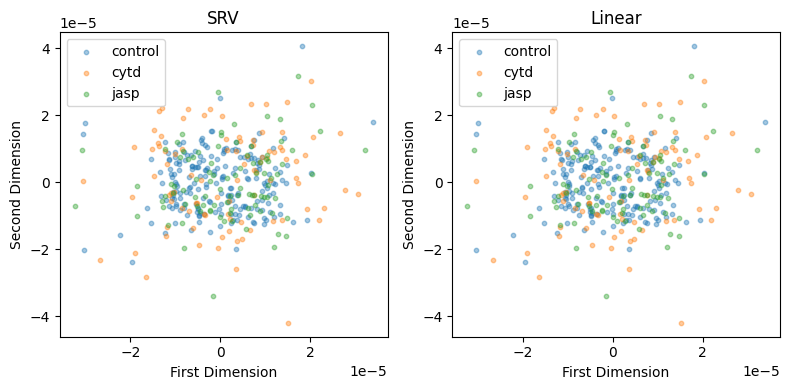

In [136]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=20)

plt.tight_layout()

plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.pdf"))


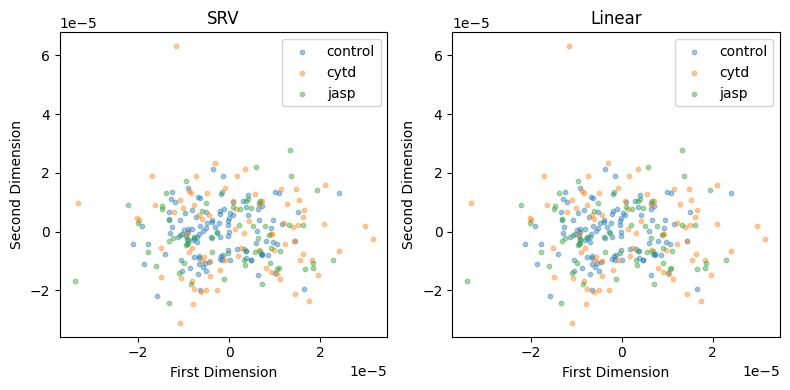

In [137]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=20)

plt.tight_layout()

plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.pdf"))


We also consider embedding in 3D. 

In [113]:
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_
print("the stress for SRV model is:", mds.stress_)
print(pairwise_dists[metric].shape)
print(pos.shape)

the stress for SRV model is: 2.2779957436365338e-05
(644, 644)
(644, 3)


In [114]:
embs = {}
metric = 'SRV'
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

In [115]:
metric = 'Linear'
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_
print("the stress for linear model is:", mds.stress_)


the stress for linear model is: 2.2779957436365338e-05


In [116]:
metric = 'Linear'
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

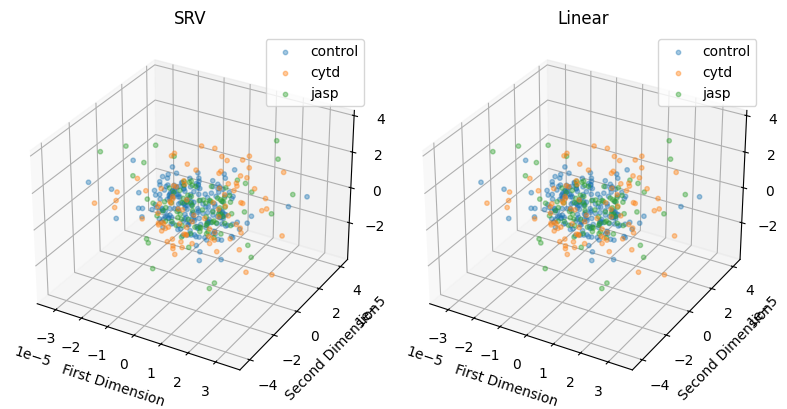

In [117]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                cur_embs[:, 2],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using linear metric", fontsize=20)

plt.tight_layout()
# plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.pdf"))


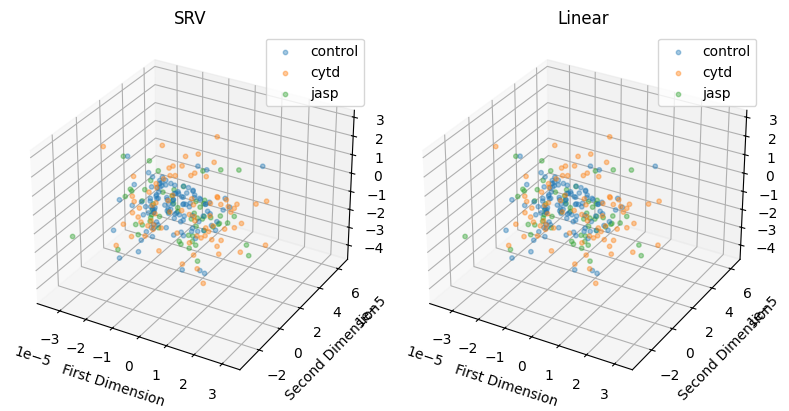

In [118]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                cur_embs[:, 2],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using linear metric", fontsize=20)

plt.tight_layout()
# plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.pdf"))


# Multi-class (3-class) classification 

We now consider one cell line at the same time, to investigate the effects of the drugs on the cell shapes. Applying the MDS again gives the following results:

In [128]:
from sklearn import svm

def knn_score(pos, labels):
    clf = KNeighborsClassifier(n_neighbors=4)
    scores = cross_val_score(clf, pos, labels, cv=5, scoring='accuracy')
    return scores.mean()

def svm_score(pos, labels):
    clf = svm.SVC(kernel='rbf', C=1)
    scores = cross_val_score(clf, pos, labels, cv=5, scoring='accuracy')
    return scores.mean()

In [129]:
lines = gs.array(lines)
treatments = gs.array(treatments)

In [130]:
for line in LINES:
    for metric in METRICS:
        control_indexes = gs.where((lines == line) & (treatments == "control"))[0]
        cytd_indexes = gs.where((lines == line) & (treatments == "cytd"))[0]
        jasp_indexes = gs.where((lines == line) & (treatments == "jasp"))[0]

        indexes = gs.concatenate((jasp_indexes, cytd_indexes, control_indexes))
        matrix = pairwise_dists[metric][indexes][:, indexes]

        mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
        pos = mds.fit(matrix).embedding_

        line_treatments = treatments[lines == line]
        line_treatments_strings, line_treatments_labels = np.unique(line_treatments, return_inverse=True)

        print(f'Score for {line} using {metric} is: {round(svm_score(pos, line_treatments_labels), 3)}')



Score for dlm8 using SRV is: 0.512
Score for dlm8 using Linear is: 0.421
Score for dunn using SRV is: 0.6
Score for dunn using Linear is: 0.518
